In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.float_format = '{:.6f}'.format

# 그래프에서 한글 깨짐 방지
import platform
if platform.system() == "Darwin":          # MAC인 경우
    plt.rc('font', family ="AppleGothic")
else:
    plt.rc('font',family='Malgun Gothic')

#멧플로립에서 음수를 표시
plt.rc('axes',unicode_minus=False)

#워닝 메시지
import warnings
warnings.filterwarnings('ignore')


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping


## 1.스케일링(standard_scale)

In [3]:
# 데이터 불러오기
df = pd.read_csv('./datasets/원본data.csv')
df['Date'] = pd.to_datetime(df['Date'])  # 'Date' 열을 datetime 객체로 변환
df.set_index('Date', inplace=True)

df=df.drop(['원위안', '유가', '은', '외환보유액','구리'],axis=1) # G7 이미 삭제된 데이터셋
dataset =df.values
# dataset=df[['재고순환지표','경제심리지수','수출입물가비율','코스피','장단기','원달러','CD','G20','종가']].values
scaler=StandardScaler()
dataset= scaler.fit_transform(dataset)
print(dataset)

[[ 0.93589755  1.43327182 -0.74157178 ...  2.07114449 -1.74913464
  -1.49457805]
 [ 0.80523213  1.42294476 -0.75485022 ...  2.01342627 -1.57284691
  -1.75012721]
 [ 0.7220814   1.26803893 -0.75485022 ...  2.85611229 -1.33988349
  -1.81061445]
 ...
 [-1.58238152 -0.73540982  0.37381684 ... -0.75285063  1.76937084
  -0.3938106 ]
 [-1.61801754 -0.73540982 -0.40961088 ... -0.59701144  1.4817088
  -0.27075728]
 [-1.66553224 -0.61148516 -0.3432187  ... -0.94751845  1.95422583
  -0.27316174]]


In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

- scaled_df : 5개의 feature 삭제하고 남은 전체 데이터프레임
- feature_df : scaled_df중 종가를 제외한 부분
- label_df : scaled_df의 종가 부분

In [5]:
scaled_df = pd.DataFrame(dataset, columns=df.columns,index=df.index)
feature_df = scaled_df[['재고순환지표', '경제심리지수', '기계류내수출', '건설수주액', '수출입물가비율', '코스피', '장단기', '뉴스심리지수', '원달러', '원엔', 'CD', 'G20', '미장단기', '거래량', '천연가스', '금','종가']]
label_df = scaled_df['종가']

#### 사용한 데이터 :  내생 변수 -> 9개

In [6]:
feature_df_2 = feature_df[['재고순환지표','경제심리지수','수출입물가비율','코스피','장단기','원달러','CD','G20','종가']]

## 2.tesnorflow에 사용될 데이터로 전처리

### 데이터프레임을 --> array형태로
    

In [7]:
feature_np = feature_df_2.to_numpy()
label_np = label_df.to_numpy()

In [8]:
feature_np.shape

(184, 9)

### tensorflow에서 사용하기 위한 데이터 형태 만들기
    - feature : 학습시킬 데이터
    - label : 예측할 데이터
    - window_size : 몇개 전 데이터로 다음값을 예측할 것인지
    - return: (row 총 개수 - windows , window_size , feature 개수) , (row 총 개수 - windows, )


#### 1. window로 3차원 텐서로 만들기

In [9]:
def make_sequence_dataset(feature, label, window_size):
  feature_list = []
  label_list = []

  for i in range(len(feature)-window_size):
    feature_list.append(feature[i:i+window_size])
    label_list.append(label[i+window_size-1])

  return np.array(feature_list), np.array(label_list) # 3차원 텐서

In [10]:
window_size=1
X, Y = make_sequence_dataset(feature_np, label_np, window_size) # batchsize, time steps ,input dims
print(X.shape,Y.shape)

(183, 1, 9) (183,)


#### 2. train,test으로 데이터 분할
    - split : 테스트 개수

In [11]:
split = -36
x_train = X[0:split]
y_train = Y[0:split]

x_test = X[split:]
y_test = Y[split:]

print(x_train.shape, y_train.shape,x_test.shape, y_test.shape)


(147, 1, 9) (147,) (36, 1, 9) (36,)


## 3. LSTM 모델링

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import get_custom_objects

def prelu_activation(x):
    alpha = tf.constant(0.1)  # P-ReLU 매개변수
    return tf.keras.activations.relu(x) - alpha * tf.keras.activations.relu(-x)

get_custom_objects().update({'prelu_activation': prelu_activation})


def e_relu_activation(x):
    alpha = tf.constant(1.0)  # e-ReLU 매개변수
    return tf.keras.activations.relu(x) - alpha * (tf.exp(x) - 1)

get_custom_objects().update({'e_relu_activation': e_relu_activation})


# LSTM 모델 생성
from keras.layers import Bidirectional

model = Sequential()
model.add(Bidirectional(LSTM(256, return_sequences=True, dropout=0.18,recurrent_dropout =0.15,activation='e_relu_activation'), input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Bidirectional(LSTM(128, return_sequences=True, dropout=0.18, recurrent_dropout=0.15,activation='tanh')))
model.add(Bidirectional(LSTM(128, return_sequences=False, dropout=0.18, recurrent_dropout=0.15,activation='e_relu_activation')))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 1, 512)           544768    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 1, 256)           656384    
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 1,595,649
Trainable params: 1,595,649
Non-trainable params: 0
______________________________________________

In [13]:
# early_stop = EarlyStopping(monitor='val_loss', patience=5)
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=130, batch_size=6, verbose=1)


Epoch 1/130
25/25 [==============================] - 12s 50ms/step - loss: 1.1424 - val_loss: 0.4459
Epoch 2/130
25/25 [==============================] - 0s 15ms/step - loss: 1.1310 - val_loss: 0.4162
Epoch 3/130
25/25 [==============================] - 0s 15ms/step - loss: 0.8653 - val_loss: 0.3711
Epoch 4/130
25/25 [==============================] - 0s 17ms/step - loss: 0.8170 - val_loss: 0.3338
Epoch 5/130
25/25 [==============================] - 0s 16ms/step - loss: 0.6428 - val_loss: 0.2954
Epoch 6/130
25/25 [==============================] - 0s 16ms/step - loss: 0.5937 - val_loss: 0.2945
Epoch 7/130
25/25 [==============================] - 0s 16ms/step - loss: 0.5246 - val_loss: 0.2484
Epoch 8/130
25/25 [==============================] - 0s 16ms/step - loss: 0.2725 - val_loss: 0.1943
Epoch 9/130
25/25 [==============================] - 0s 17ms/step - loss: 0.2515 - val_loss: 0.1740
Epoch 10/130
25/25 [==============================] - 0s 16ms/step - loss: 0.1831 - val_loss: 0.147

## 4.예측 및 시각화

2/2 [==============================] - 1s 3ms/step


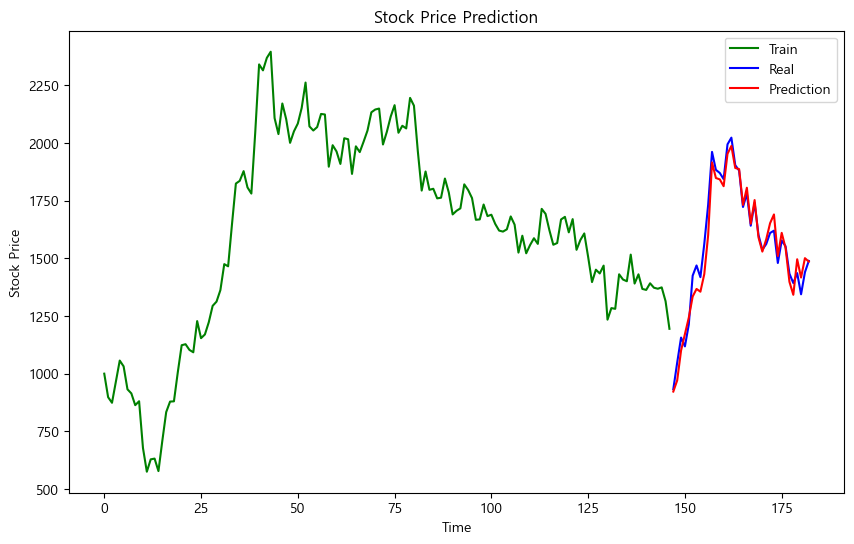

In [14]:
# 예측
val_predict = model.predict(x_test)

# 역 변환기
scaler_y = StandardScaler()
scaled_data_y = scaler_y.fit_transform(df.iloc[:, -1].values.reshape(-1,1))

# 예측 값 스케일 역변환
val_predict = scaler_y.inverse_transform(val_predict)

# 실제 값 스케일 역변환
y_train = scaler_y.inverse_transform(y_train.reshape(-1,1))
y_test = scaler_y.inverse_transform(y_test.reshape(-1,1))

plt.figure(figsize=(10,6))
# Add the training set to the plot:
plt.plot(y_train, color='green', label='Train')
# Plot the test and prediction data:
plt.plot(range(len(y_train), len(y_train)+len(y_test)), y_test, color='blue', label='Real')
plt.plot(range(len(y_train), len(y_train)+len(y_test)), val_predict, color='red', label='Prediction')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()




In [21]:
val_predict

array([[ 922.4924],
       [ 970.6705],
       [1100.1455],
       [1171.6609],
       [1242.9229],
       [1334.2938],
       [1367.1554],
       [1355.2076],
       [1431.4348],
       [1600.5668],
       [1915.3651],
       [1847.92  ],
       [1841.8848],
       [1812.3778],
       [1952.8112],
       [1986.8273],
       [1891.3046],
       [1886.4153],
       [1731.385 ],
       [1805.6921],
       [1649.6355],
       [1752.319 ],
       [1590.8301],
       [1528.9836],
       [1581.7947],
       [1652.1311],
       [1689.953 ],
       [1509.6239],
       [1610.2063],
       [1544.4928],
       [1397.9141],
       [1341.7616],
       [1495.7057],
       [1416.4714],
       [1500.5272],
       [1485.5018]], dtype=float32)

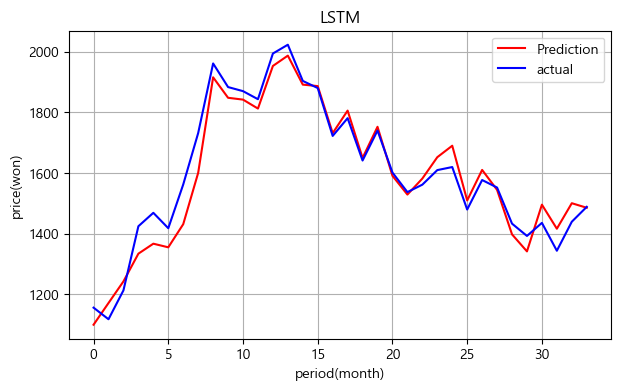

In [20]:
# 예측

plt.figure(figsize=(7,4))
plt.title('LSTM')
plt.ylabel('price(won)')
plt.xlabel('period(month)')
plt.plot(val_predict[2:], label = 'Prediction', color='r')
plt.plot(y_test[2:], label = 'actual', color='b')
plt.legend(loc='best')
plt.show()

## 5. 평가지표

In [17]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

#Calculate mean absolute error
mae = mean_absolute_error(val_predict[2:],y_test[2:])
print('MAE: %f' % mae)

#Calculate mean squared error and root mean squared error
mse = mean_squared_error(val_predict[2:], y_test[2:])
print('MSE: %f' % mse)
rmse = np.sqrt(mse)
print('RMSE: %f' % rmse)

#Calculate mean_absolute_percentage_error
mape = mean_absolute_percentage_error(val_predict[2:],y_test[2:])
print('MAPE: %f' % mape)

MAE: 42.696038
MSE: 2901.825155
RMSE: 53.868592
MAPE: 0.028601


In [18]:
pred = pd.Series(val_predict.flatten()).pct_change()
test = pd.Series(y_test.flatten()).pct_change()

In [19]:
re = 1
for i in range(len(pred)):
  if pred[i] > 0:
    re *= (1+test[i])

re

3.2483523697138175

In [23]:
df = pd.DataFrame({
    '예측': val_predict.flatten(),
    '종가': y_test.flatten()
})
# df


In [24]:
df['trade'] = ''

df['trade'] = np.where(df['예측'].shift(-1) > df['예측'], 'buy', '')
df['buy_price'] = df.loc[df['trade'] == 'buy', '종가']
df['next_day_price'] = df['종가'].shift(-1)  # 다음 날의 종가를 새로운 컬럼으로 추가
df['profit'] = np.where(df['trade'] == 'buy', df['next_day_price'] - df['buy_price'], np.nan)  # 수익 계산
df['return'] = df['profit'] / df['buy_price']  # 수익률 계산
df['profit'] = df['profit'].fillna(0)
df['return'] = df['return'].fillna(0)
# df

,예측,종가,trade,buy_price,next_day_price,profit,return
0,922.492371,932.770000,buy,932.770000,1047.710000,114.940000,0.123224
1,970.670471,1047.710000,buy,1047.710000,1156.360000,108.650000,0.103702
2,1100.145508,1156.360000,buy,1156.360000,1118.170000,-38.190000,-0.033026
3,1171.660889,1118.170000,buy,1118.170000,1213.420000,95.250000,0.085184
4,1242.922852,1213.420000,buy,1213.420000,1424.680000,211.260000,0.174103
5,1334.293823,1424.680000,buy,1424.680000,1468.870000,44.190000,0.031017
6,1367.155396,1468.870000,,NaN,1418.120000,0.000000,0.000000
7,1355.207642,1418.120000,buy,1418.120000,1562.350000,144.230000,0.101705
8,1431.434814,1562.350000,buy,1562.350000,1731.680000,169.330000,0.108382
9,1600.566772,1731.680000,buy,1731.680000,1960.990000,229.310000,0.132421


In [32]:
ret = 1
cum_ret = []
for value in df['return']:
    if not pd.isnull(value):
        ret *= (1 + value)
    cum_ret.append(ret)
df['누적 수익률'] = cum_ret
df


,예측,종가,trade,buy_price,next_day_price,profit,return,누적 수익률
0,922.492371,932.770000,buy,932.770000,1047.710000,114.940000,0.123224,1.123224
1,970.670471,1047.710000,buy,1047.710000,1156.360000,108.650000,0.103702,1.239705
2,1100.145508,1156.360000,buy,1156.360000,1118.170000,-38.190000,-0.033026,1.198763
3,1171.660889,1118.170000,buy,1118.170000,1213.420000,95.250000,0.085184,1.300878
4,1242.922852,1213.420000,buy,1213.420000,1424.680000,211.260000,0.174103,1.527365
5,1334.293823,1424.680000,buy,1424.680000,1468.870000,44.190000,0.031017,1.574740
6,1367.155396,1468.870000,,NaN,1418.120000,0.000000,0.000000,1.574740
7,1355.207642,1418.120000,buy,1418.120000,1562.350000,144.230000,0.101705,1.734899
8,1431.434814,1562.350000,buy,1562.350000,1731.680000,169.330000,0.108382,1.922930
9,1600.566772,1731.680000,buy,1731.680000,1960.990000,229.310000,0.132421,2.177565
